In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

### Zadanie 1.
Zastosuj zaimplementowaną metodę Eulera do rozwiązania zagadnienia 
$$y'(t) = 1 - y(t), \quad y(0) = 0.$$
Oblicz przybliżone rozwiązanie dla kroku $h=0,02$, $h=0,01$ oraz $h=0,005$, a następnie zaobserwuj jak zmienia się błąd rozwiązania (porównując z rozwiązaniem analitycznym). Czy da się dostrzec jakąś prawidłowość?

In [1]:
def euler_step(fun, t, y, h):
    """
    Pojedynczy krok w metodzie Eulera.
    
    Parametry
    ----------
    fun : obiekt wywoływalny (callable)
        Prawa strona układu równań.
    t : float
        Aktualny krok czasowy.
    y : ndarray, wymiaru (n,)
        Aktualna wartość rozwiązania.
    h : float
        Krok czasowy.
    
    Zwraca
    -------
    y_new : ndarray, wymiaru (n,)
        Rozwiązanie przybliżone w punkcie t + h.
    """
    y_new = y + h * fun(t, y)
    return y_new

In [3]:
class Euler(integrate.OdeSolver):
    """
    Stałokrokowa otwarta metoda Eulera (rzędu 1).
    
    (parametry i atrybuty jak w metodach zaimplementowanych w pakiecie `SciPy`.)
    """
    def __init__(self, fun, t0, y0, t_bound, max_step=np.inf, 
                 rtol=1e-3, atol=1e-6, vectorized=False,
                 first_step=None, **extraneous):
        integrate._ivp.common.warn_extraneous(extraneous)
        super(Euler, self).__init__(fun, t0, y0, t_bound, vectorized, 
                                    support_complex=True)
        self.y_old = None
        self.t0 = t0
        self.max_step = integrate._ivp.common.validate_max_step(max_step)
        self.error_estimator_order = 1
        self.rtol, self.atol = integrate._ivp.common.validate_tol(rtol, atol, self.n)
        self.f = self.fun(self.t, self.y)
        if first_step is None:
            self.h_abs = integrate._ivp.common.select_initial_step(
                self.fun, self.t, self.y, self.f, self.direction,
                self.error_estimator_order, self.rtol, self.atol)
        else:
            self.h_abs = integrate._ivp.common.validate_first_step(first_step, t0, t_bound)

    def _step_impl(self):
        t = self.t
        y = self.y
        self.y_old = y
        
        self.t = t + self.h_abs * self.direction
        self.y = euler_step(self.fun, t, y, self.h_abs * self.direction)

        return True, None
    
    def _dense_output_impl(self):
        return None

In [11]:
def fun(t, y):
    "Prawa strona równania y' = 1 - y."
    return 1-y

In [55]:
tspan = [0, 3]
x0 = [0]
hs = [0.02, 0.01, 0.005]
sol_true = lambda t: 1 - np.exp(-t)

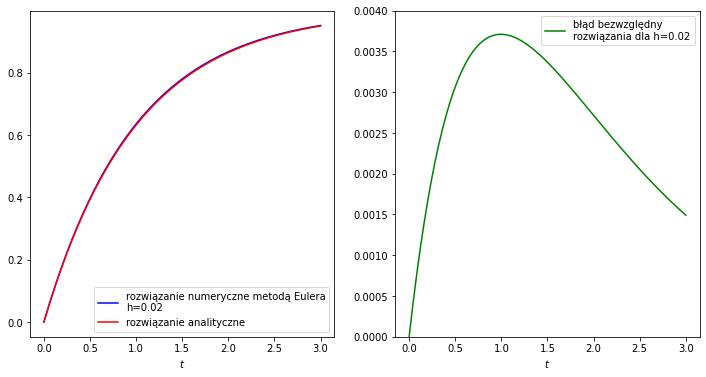

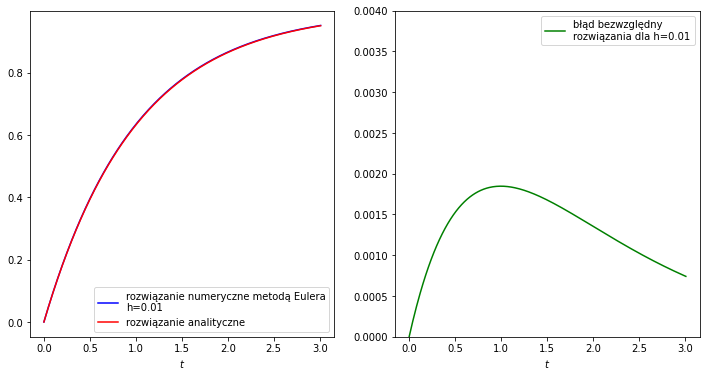

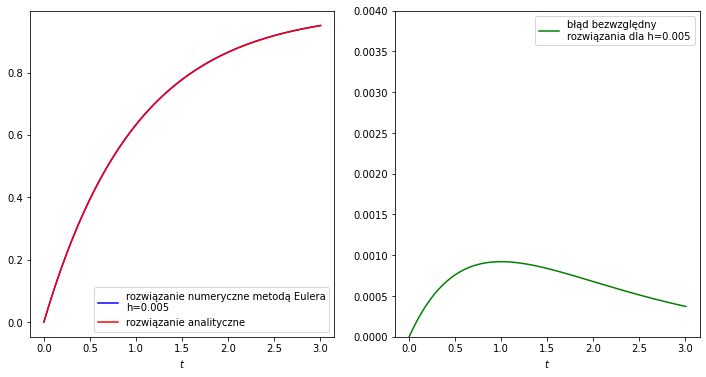

In [56]:
for h in hs:
    sol_euler = integrate.solve_ivp(fun, tspan, x0, method = Euler, first_step = h)
    error = np.abs(sol_euler.y[0] - sol_true(sol_euler.t))
    _, axes = plt.subplots(1, 2, figsize=(12,6))
    axes[0].plot(sol_euler.t, sol_euler.y[0], 'b', label=f"rozwiązanie numeryczne metodą Eulera\nh={h}")
    axes[0].plot(sol_euler.t, sol_true(sol_euler.t), 'r', label="rozwiązanie analityczne")
    axes[0].set_xlabel("$t$")
    axes[0].legend()

    axes[1].plot(sol_euler.t, error, 'g', label=f"błąd bezwzględny\nrozwiązania dla h={h}")
    axes[1].set_xlabel("$t$")
    axes[1].set_ylim(0, 0.004)
    axes[1].legend()

    plt.show()

## Krótkie omówienie:
Analiza błędu rozwiązania dla róznych wartości skoku wykazała, że maksymalny błąd bezwzględny może rosnąć proporcjonalnie z wartością skoku, co zgodne jest z wnioskami z wykładu.

### Zadanie 2.
Zaimplementuj *ulepszoną metodę Eulera* (z wykładu) czyli przykład metody RK2:
$$y_{i+1} = y_i + h\cdot(b_1 k_1 + b_2 k_2), \quad
b_1 = b_2 = \frac{1}{2}, \quad
k_1 = f(t_i, y_i), \quad
k_2 = f(t_i + h, y_i + hk_1).$$
Następnie zastosuj ją do zagadnienia z Zadania 1 i wyciągnij analogiczne wnioski.

In [57]:
def rk2_step(fun, t, y, h):
    """
    Pojedynczy krok w metodzie RK2.
    
    Parametry
    ----------
    fun : obiekt wywoływalny (callable)
        Prawa strona układu równań.
    t : float
        Aktualny krok czasowy.
    y : ndarray, wymiaru (n,)
        Aktualna wartość rozwiązania.
    h : float
        Krok czasowy.
    
    Zwraca
    -------
    y_new : ndarray, wymiaru (n,)
        Rozwiązanie przybliżone w punkcie t + h.
    """
    B = [0.5, 0.5]
    k1 = fun(t, y)
    k2 = fun(t + h, y + h * k1)
    y_new = y + h * np.dot(B, [k1, k2])
    return y_new

In [58]:
class RK2(integrate.OdeSolver):
    """
    Stałokrokowa jawna metoda Runge-Kutty (rzędu 2).
    
    (parametry i atrybuty jak w metodach zaimplementowanych w pakiecie `SciPy`.)
    """
    def __init__(self, fun, t0, y0, t_bound, max_step=np.inf, 
                 rtol=1e-3, atol=1e-6, vectorized=False,
                 first_step=None, **extraneous):
        integrate._ivp.common.warn_extraneous(extraneous)
        super(RK2, self).__init__(fun, t0, y0, t_bound, vectorized, 
                                    support_complex=True)
        self.y_old = None
        self.t0 = t0
        self.max_step = integrate._ivp.common.validate_max_step(max_step)
        self.error_estimator_order = 2
        self.rtol, self.atol = integrate._ivp.common.validate_tol(rtol, atol, self.n)
        self.f = self.fun(self.t, self.y)
        if first_step is None:
            self.h_abs = integrate._ivp.common.select_initial_step(
                self.fun, self.t, self.y, self.f, self.direction,
                self.error_estimator_order, self.rtol, self.atol)
        else:
            self.h_abs = integrate._ivp.common.validate_first_step(first_step, t0, t_bound)

    def _step_impl(self):
        t = self.t
        y = self.y
        self.y_old = y
        
        self.t = t + self.h_abs * self.direction
        self.y = rk2_step(self.fun, t, y, self.h_abs * self.direction)

        return True, None
    
    def _dense_output_impl(self):
        return None

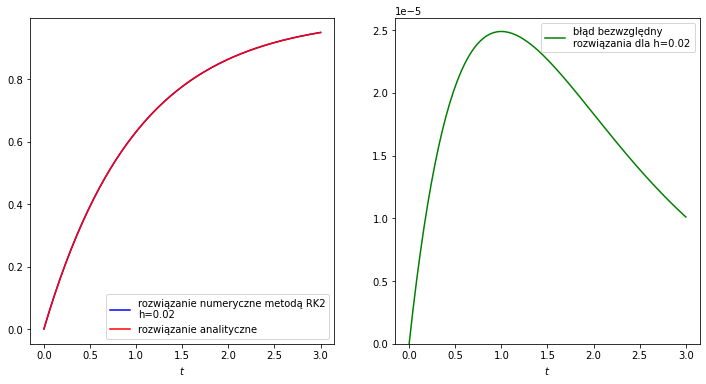

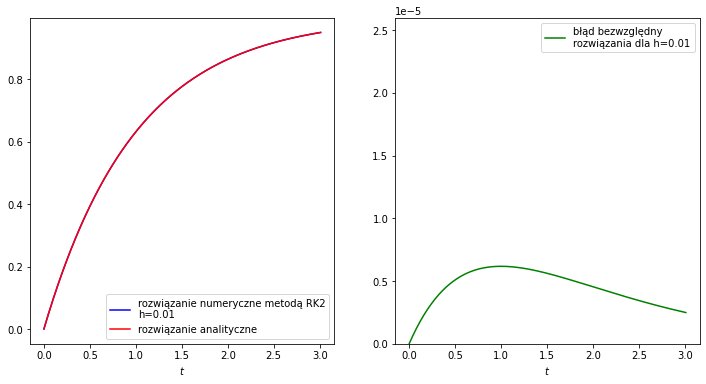

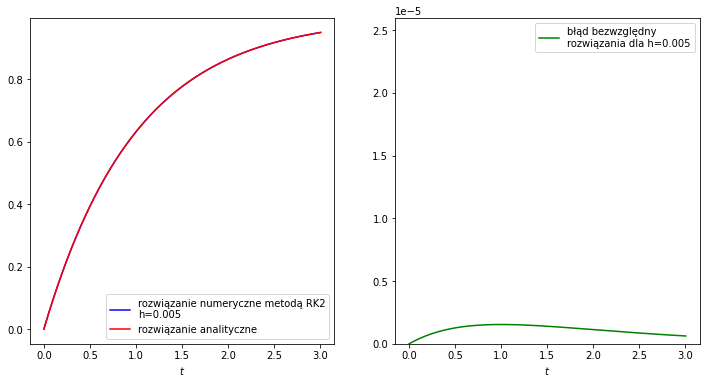

In [59]:
for h in hs:
    sol_rk2 = integrate.solve_ivp(fun, tspan, x0, method = RK2, first_step = h)
    error = np.abs(sol_rk2.y[0] - sol_true(sol_rk2.t))
    _, axes = plt.subplots(1, 2, figsize=(12,6))
    axes[0].plot(sol_rk2.t, sol_rk2.y[0], 'b', label=f"rozwiązanie numeryczne metodą RK2\nh={h}")
    axes[0].plot(sol_rk2.t, sol_true(sol_rk2.t), 'r', label="rozwiązanie analityczne")
    axes[0].set_xlabel("$t$")
    axes[0].legend()

    axes[1].plot(sol_rk2.t, error, 'g', label=f"błąd bezwzględny\nrozwiązania dla h={h}")
    axes[1].set_xlabel("$t$")
    axes[1].set_ylim(0, 2.6e-5)
    axes[1].legend()

    plt.show()

Tym razem błąd absolutny jest znacznie mniejszy oraz maleje dużo szybciej niż przy metodzie Eulera.

### Zadanie 3.
Zaimplementuj modyfikację zmiennokrokową metody RK4 (tzn. odpowiednio zmodyfikuj klasę i funkcję `_step_impl`).
Następnie zastosuj ją do zagadnienia z Zadania 1 i sprawdź jak zmieni się liczba wykonanych kroków (i ich wielkość) w porównaniu do metody stałokrokowej. 

In [60]:
def rk4_step(fun, t, y, h):
    """
    Pojedynczy krok w metodzie RK4.
    
    Parametry
    ----------
    fun : obiekt wywoływalny (callable)
        Prawa strona układu równań.
    t : float
        Aktualny krok czasowy.
    y : ndarray, wymiaru (n,)
        Aktualna wartość rozwiązania.
    h : float
        Krok czasowy.
    
    Zwraca
    -------
    y_new : ndarray, wymiaru (n,)
        Rozwiązanie przybliżone w punkcie t + h.
    """
    B = [1 / 6, 1 / 3, 1 / 3, 1 / 6]
    k1 = fun(t, y)
    k2 = fun(t + h / 2, y + h * k1 / 2)
    k3 = fun(t + h / 2, y + h * k2 / 2)
    k4 = fun(t + h, y + h * k3)
    y_new = y + h * np.dot(B, [k1, k2, k3, k4])
    return y_new

In [61]:
class RK4Mod(integrate.OdeSolver):
    """
    Zmiennokrokowa metoda RK4
    """
    def __init__(self, fun, t0, y0, t_bound, max_step=np.inf, 
                 rtol=1e-3, atol=1e-6, vectorized=False,
                 first_step=None, **extraneous):
        integrate._ivp.common.warn_extraneous(extraneous)
        super(RK4Mod, self).__init__(fun, t0, y0, t_bound, vectorized, 
                                    support_complex=True)
        self.y_old = None
        self.t0 = t0
        self.max_step = integrate._ivp.common.validate_max_step(max_step)
        self.error_estimator_order = 4
        self.rtol, self.atol = integrate._ivp.common.validate_tol(rtol, atol, self.n)
        self.f = self.fun(self.t, self.y)
        if first_step is None:
            self.h_abs = integrate._ivp.common.select_initial_step(
                self.fun, self.t, self.y, self.f, self.direction,
                self.error_estimator_order, self.rtol, self.atol)
        else:
            self.h_abs = integrate._ivp.common.validate_first_step(first_step, t0, t_bound)

    def _step_impl(self):
        t = self.t
        y = self.y
        h = self.h_abs
        self.y_old = y
        
        step_accepted = False
        rho = 0.5
        
        while not step_accepted:
            # obliczamy y_{i+1} dwiema metodami
            y1 = rk4_step(self.fun, t, y, h * self.direction)
            y2 = rk4_step(self.fun, t, y, h * self.direction / 2)
            y2 = rk4_step(self.fun, t + h * self.direction / 2, y2, h * self.direction / 2)
        
            # obliczamy błąd obcięcia (metoda rzędu 1)
            r = integrate._ivp.common.norm(y2 - y1)
            rmax = h * self.atol / (self.t_bound - self.t0)
        
            # czy modyfikujemy krok?
            if r <= rmax:
                step_accepted = True
                self.t = t + h * self.direction
                if r <= rho * rmax:
                    h = h / max(0.1, np.power(r / rmax, 1/5))
            else:
                h = h / min(10, np.power(r / rmax, 1/5))
            
        self.y = y2
        self.h_abs = h

        return True, None
    
    def _dense_output_impl(self):
        return None

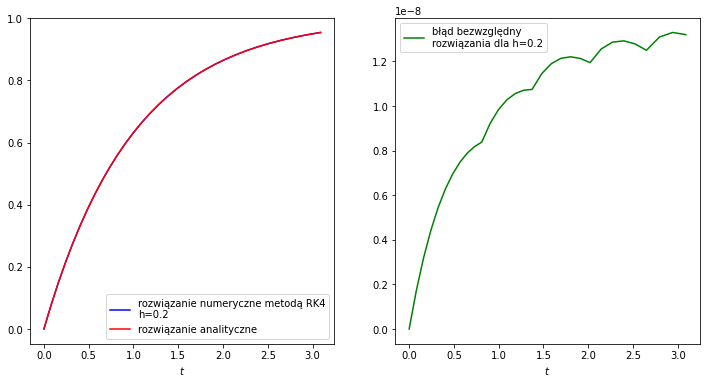

In [64]:
sol_rk4_mod = integrate.solve_ivp(fun, tspan, x0, method = RK4Mod, first_step = 0.2)
error = np.abs(sol_rk4_mod.y[0] - sol_true(sol_rk4_mod.t))
_, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].plot(sol_rk4_mod.t, sol_rk4_mod.y[0], 'b', label=f"rozwiązanie numeryczne metodą RK4\nh=0.2")
axes[0].plot(sol_rk4_mod.t, sol_true(sol_rk4_mod.t), 'r', label="rozwiązanie analityczne")
axes[0].set_xlabel("$t$")
axes[0].legend()
axes[1].plot(sol_rk4_mod.t, error, 'g', label=f"błąd bezwzględny\nrozwiązania dla h=0.2")
axes[1].set_xlabel("$t$")
axes[1].legend()

plt.show()

Sprawdziłem również, że zmiana parametru h nie wpływała na wartość błędu bezwzględnego.

In [63]:
sol_rk4_mod.t.shape

(31,)

In [66]:
sol_euler.t.shape

(602,)

In [67]:
sol_rk2.t.shape

(602,)

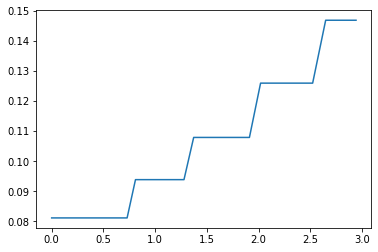

In [69]:
plt.plot(sol_rk4_mod.t[0:-1], sol_rk4_mod.t[1:] - sol_rk4_mod.t[0:-1])
plt.show()

Najwidoczniej funkcja będąca rozwiązaniem zagadnienia jest na tyle spokojna, że zmiennokrokowa metoda RK4 nie potrzebowała wielu iteracji.